In [1]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn
import alias.detection as detect

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from astropy.io import fits

plt.rcParams.update({'font.size': 10})

%matplotlib inline

/mnt_home/jhand/alias/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

exclude = []

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls if url not in exclude]

ds = alias.loadDataset(files)

/mnt_home/jhand/alias/alias/__init__.py:59: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


In [3]:
norm_flux, norm_ivar, _ = cn.continuum_normalize(ds.flux, ds.ivar)
residuals = norm_flux - np.nanmedian(norm_flux, axis=0)

In [4]:
detections = detect.detect_all(ds.wave, residuals, ds.ivar)

(15800.0, 15820.0)

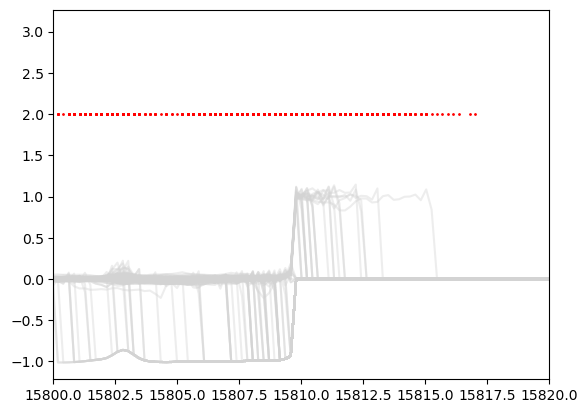

In [5]:
plt.scatter(ds.wave[detections[:,1]], [2]*len(detections), s=1, color='red')
plt.plot(ds.wave, residuals[0:100].T, alpha=0.4, color='lightgray')

plt.xlim(15800, 15820)

In [6]:
len(detections)

63170

In [7]:
hist = np.array([0]*len(ds.wave))
hist_partial = np.bincount(detections[:,1])
hist[0:len(hist_partial)] = hist_partial
mask = hist > 1

In [8]:
unique_detections = detections[~mask[detections[:,1]],:]

In [62]:
len(unique_detections)

806

In [13]:
characteristics = np.array([ detect.characterize(ds.wave, residuals[n], ds.ivar[n], peak) for n,peak in unique_detections ])

/mnt_home/jhand/alias/alias/detection.py:23: RuntimeWarning: divide by zero encountered in power
  chi2 = [ _chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), 0.3, center) for center in center_idx ]
/mnt_home/jhand/alias/alias/detection.py:31: RuntimeWarning: divide by zero encountered in power
  chi2 = [ _chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, best_idx) for amp in amps ]


(array([ 31.,  38., 164., 241., 105.,  28.,  23.,  21.,   6.,   9.,  11.,
          9.,   5.,   5.,   2.,   9.,  25.,  10.,  12.,   9.,   9.,   8.,
          4.,   4.,   3.,   3.,   1.,   1.,   5.,   5.]),
 array([0.03967966, 0.18386996, 0.32806027, 0.47225058, 0.61644088,
        0.76063119, 0.9048215 , 1.0490118 , 1.19320211, 1.33739242,
        1.48158272, 1.62577303, 1.76996334, 1.91415365, 2.05834395,
        2.20253426, 2.34672457, 2.49091487, 2.63510518, 2.77929549,
        2.92348579, 3.0676761 , 3.21186641, 3.35605671, 3.50024702,
        3.64443733, 3.78862764, 3.93281794, 4.07700825, 4.22119856,
        4.36538886]),
 <BarContainer object of 30 artists>)

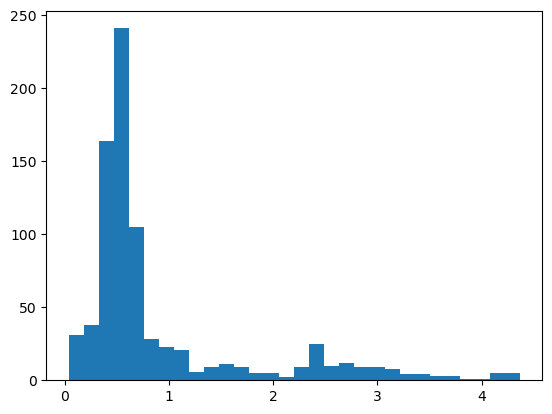

In [14]:
plt.hist(characteristics[:,2], bins=30)

In [80]:
candidates = unique_detections[(characteristics[:,2] > 0.7)]

print(len(candidates))

254


/tmp/ipykernel_3874384/948369416.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))


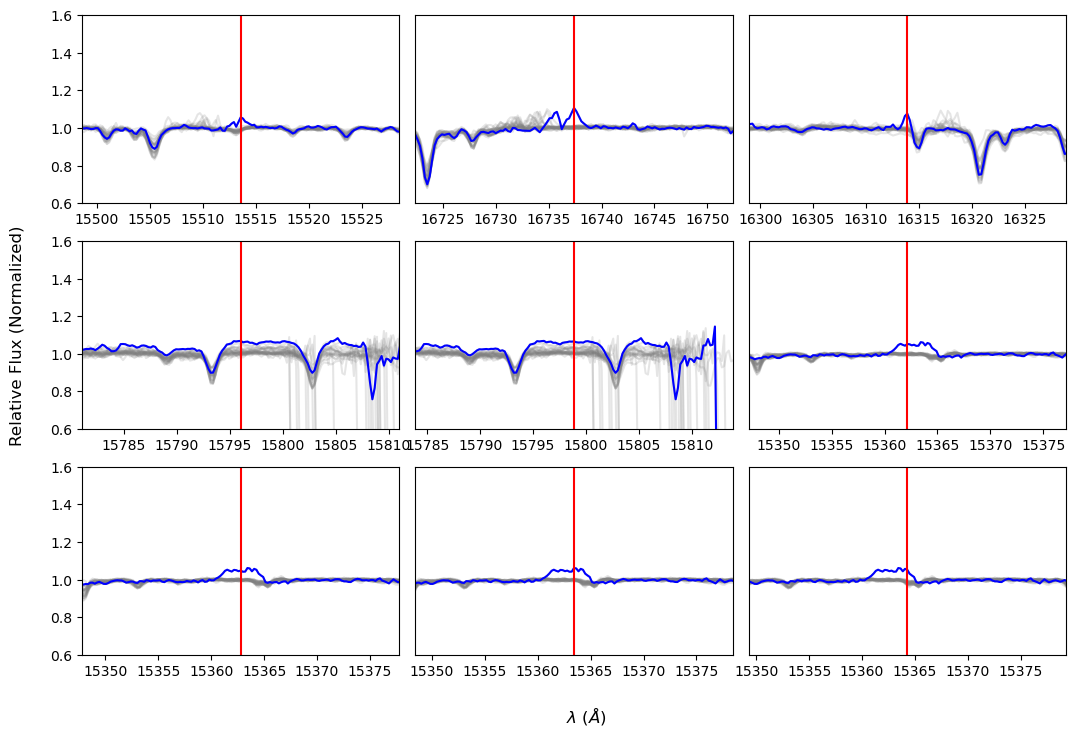

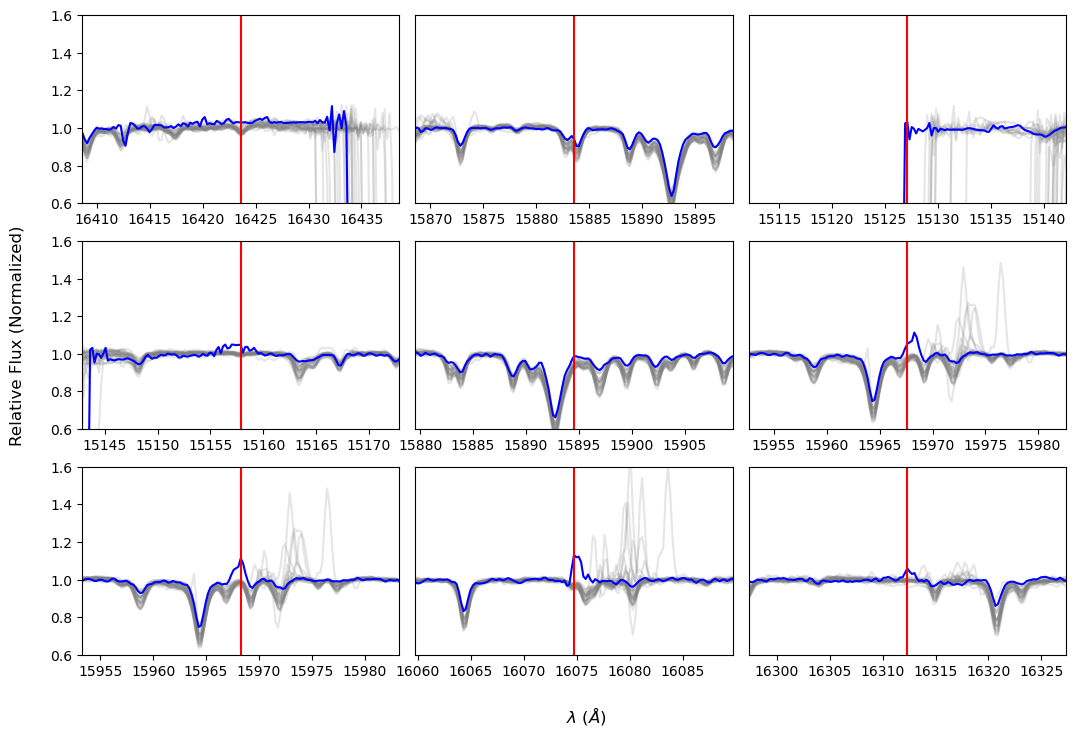

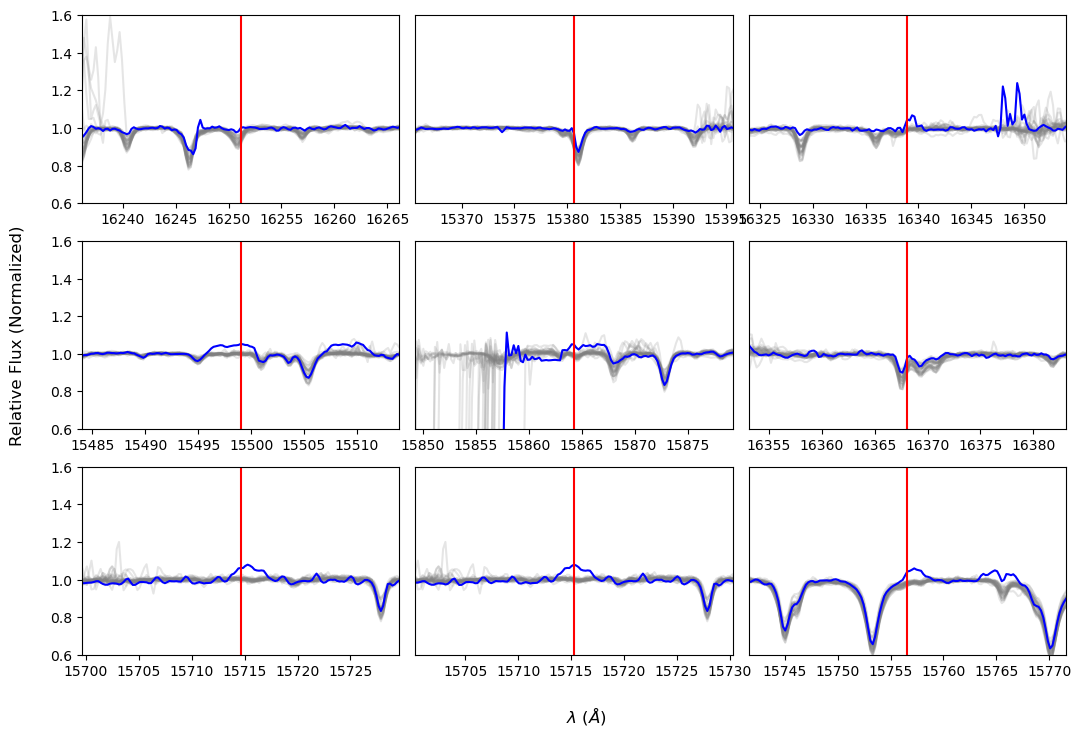

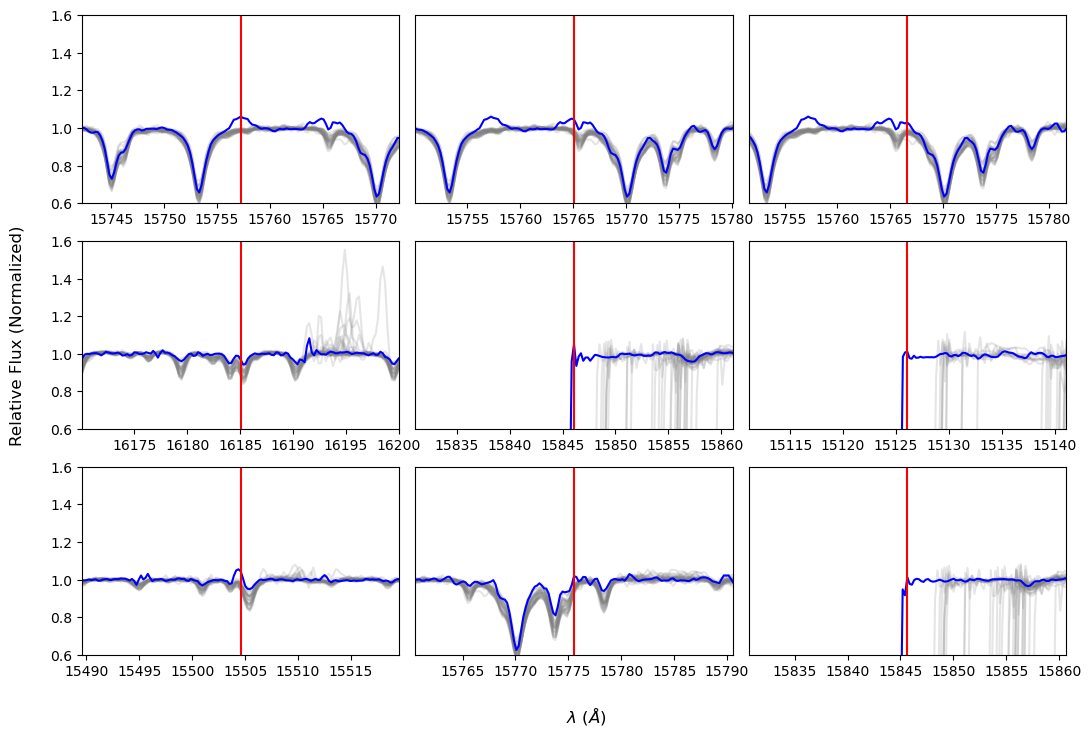

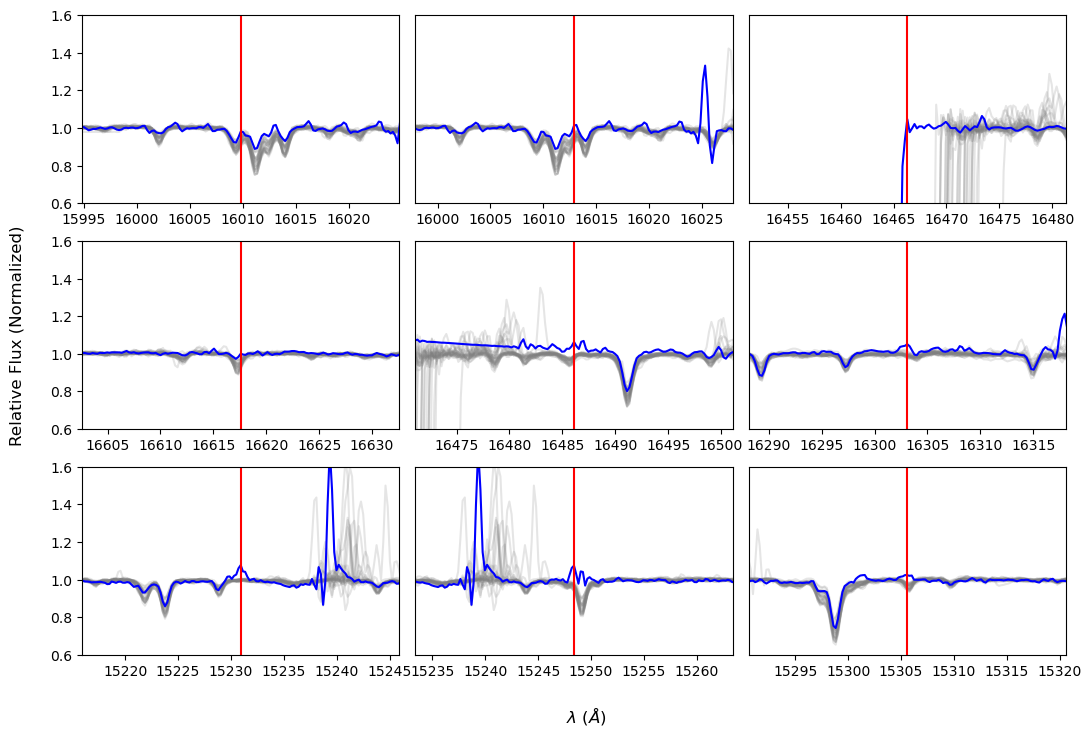

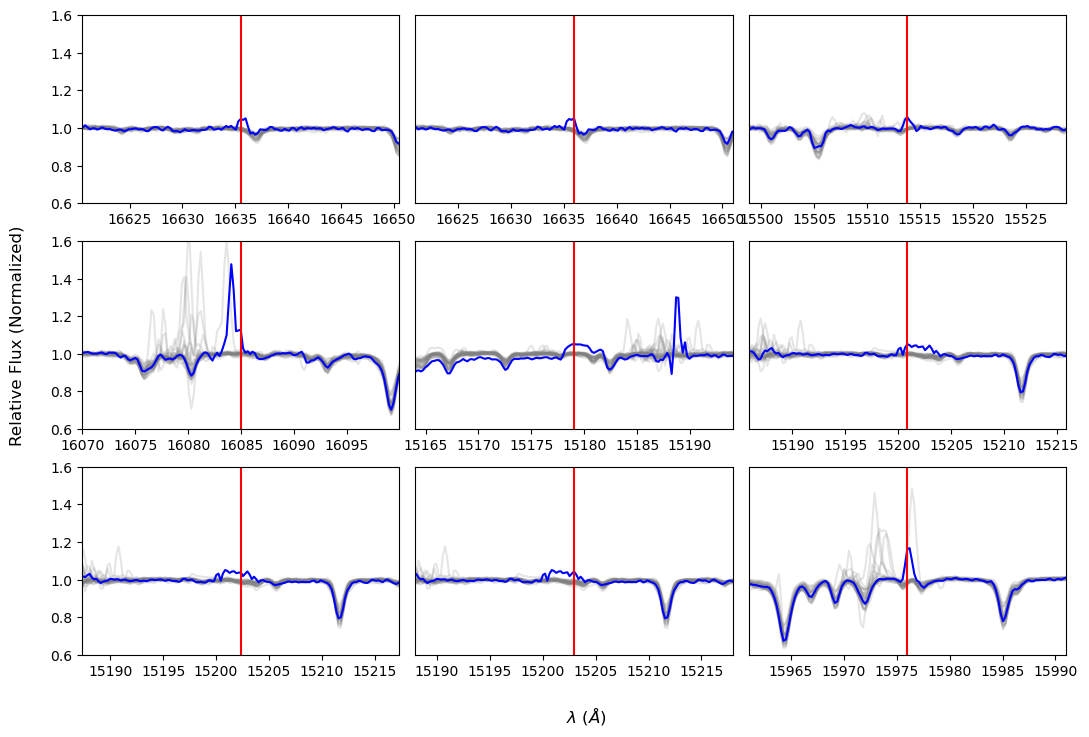

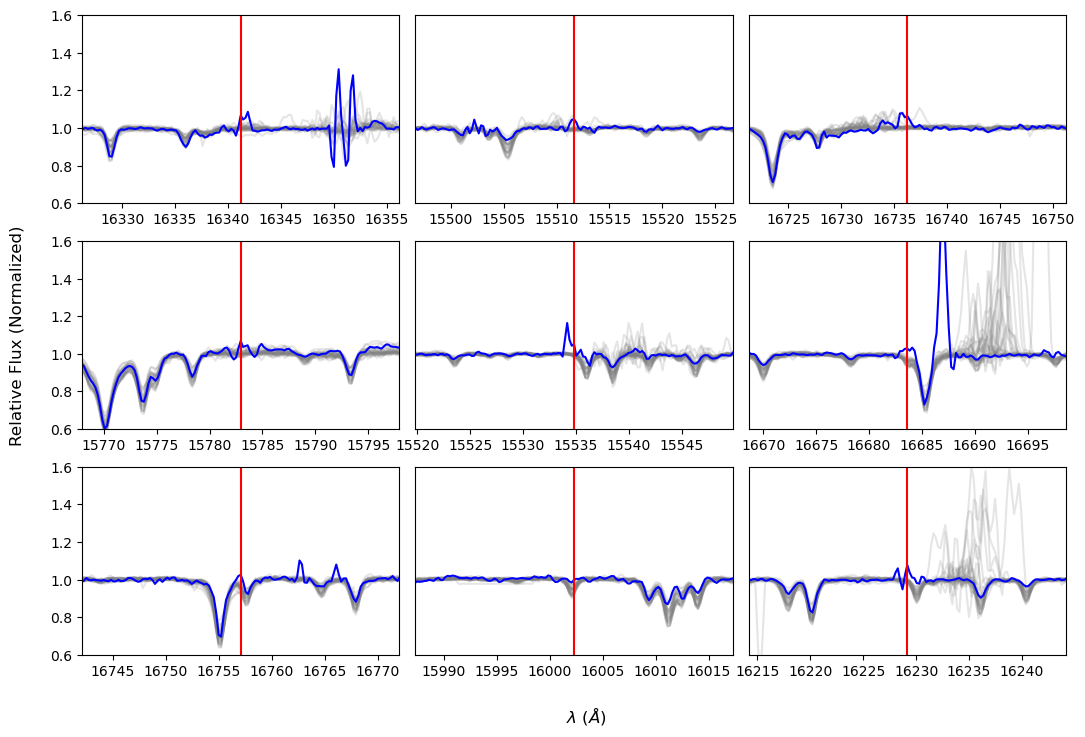

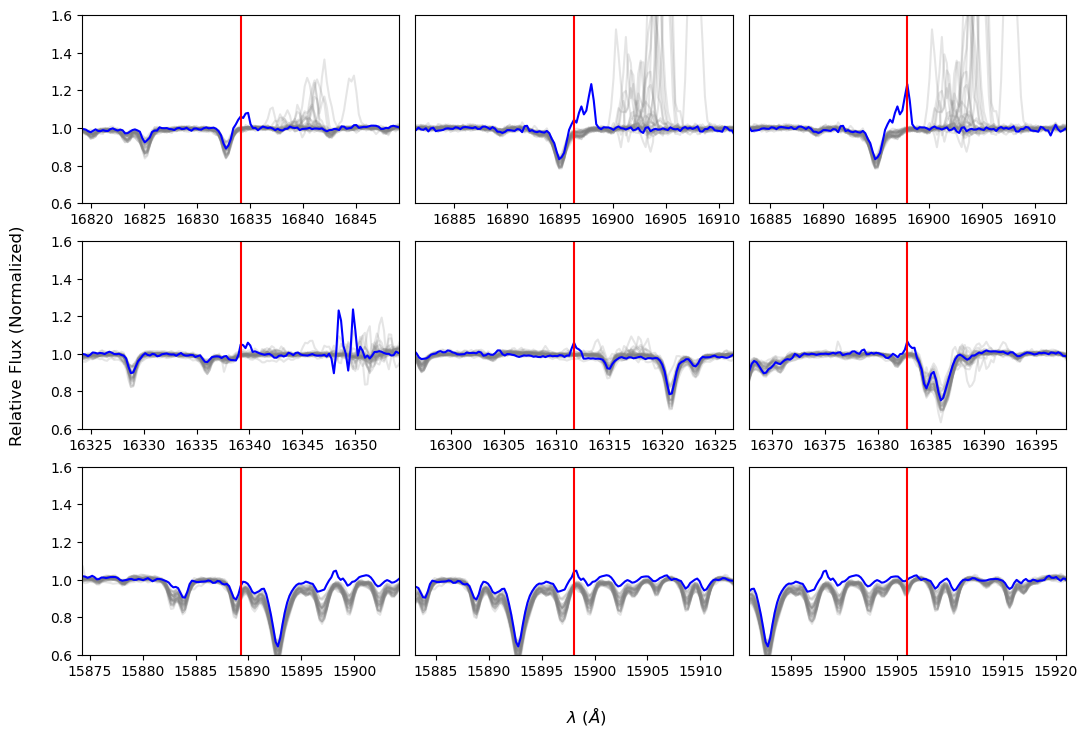

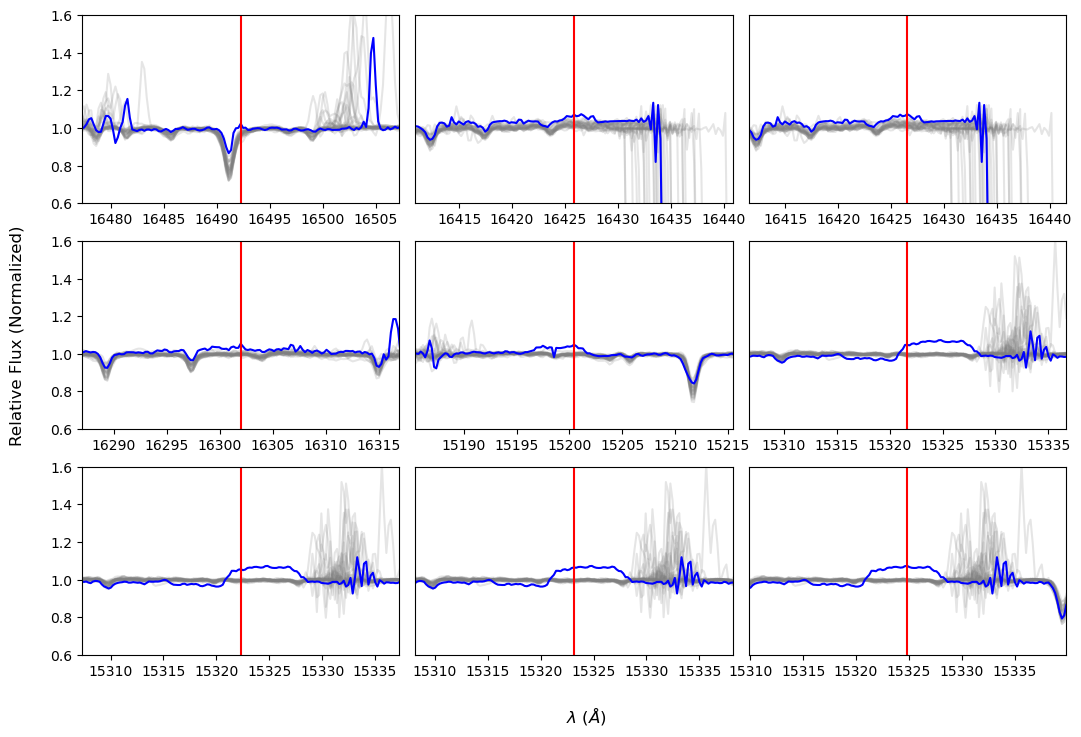

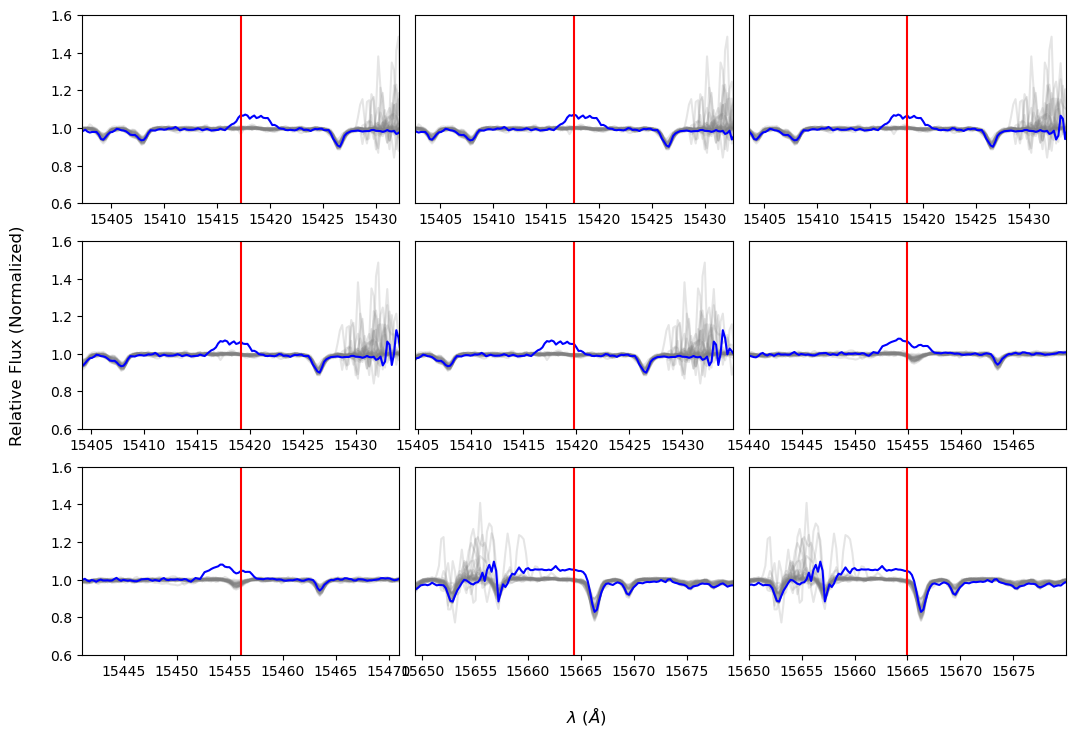

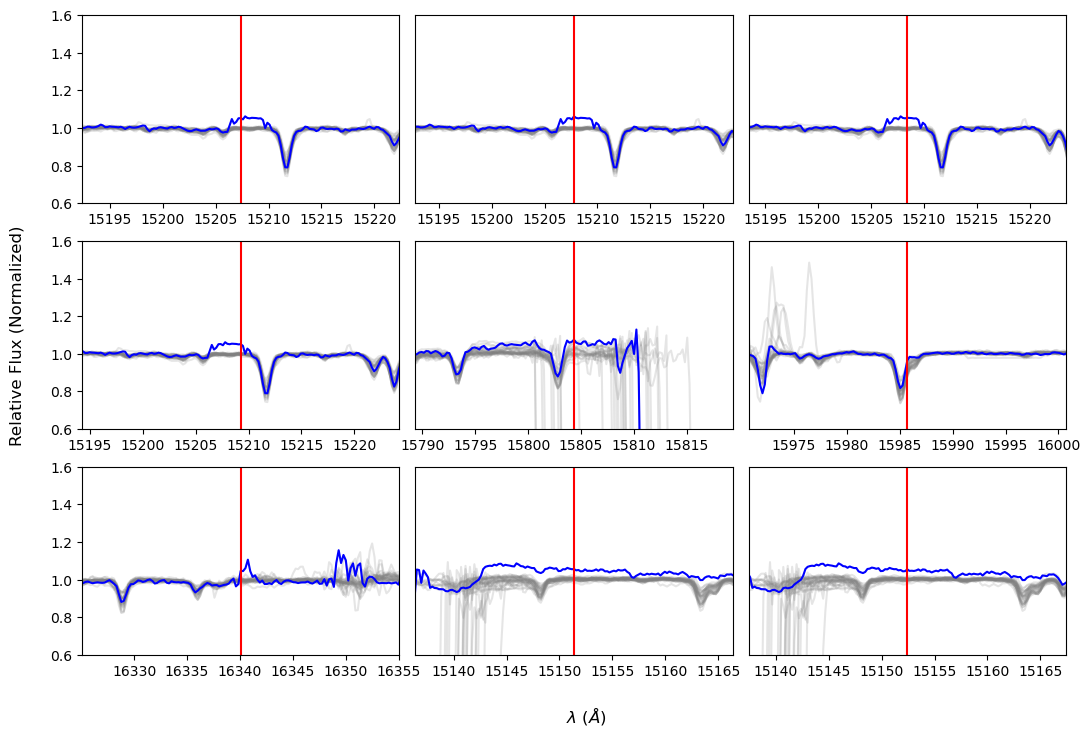

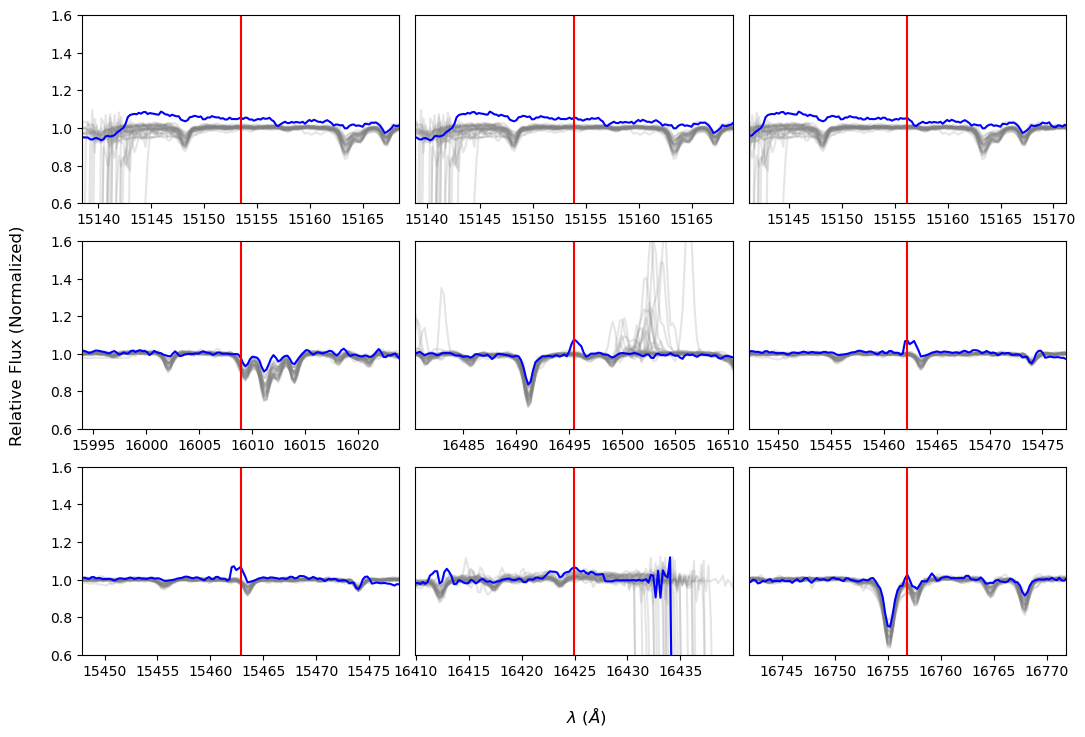

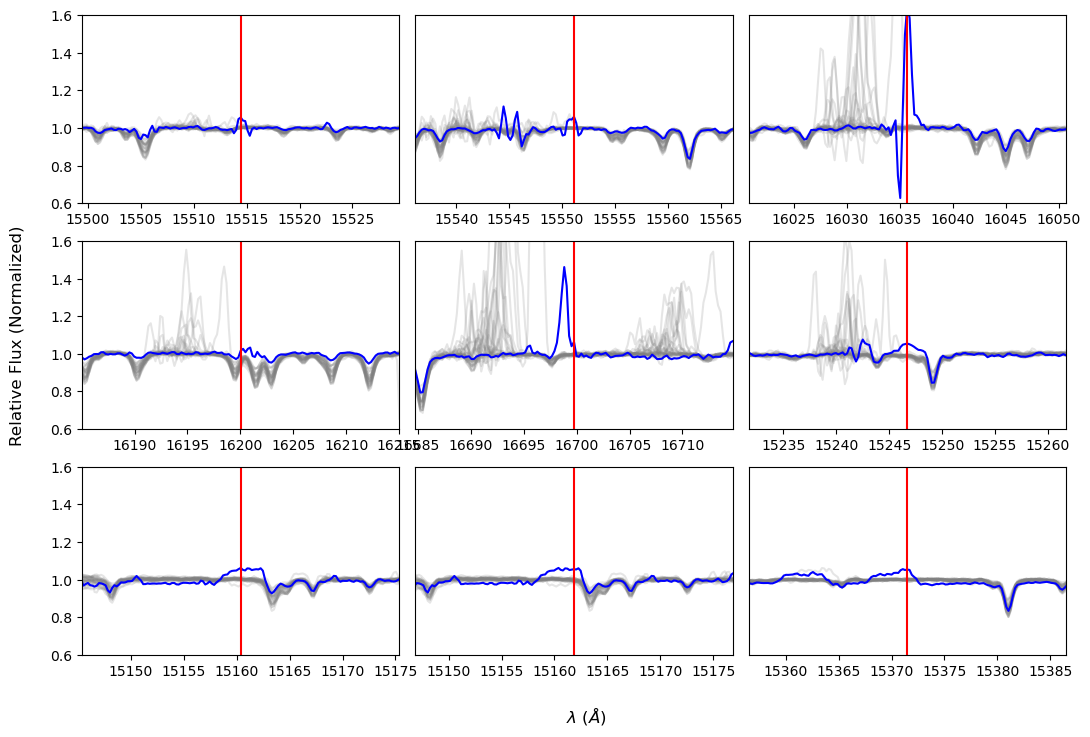

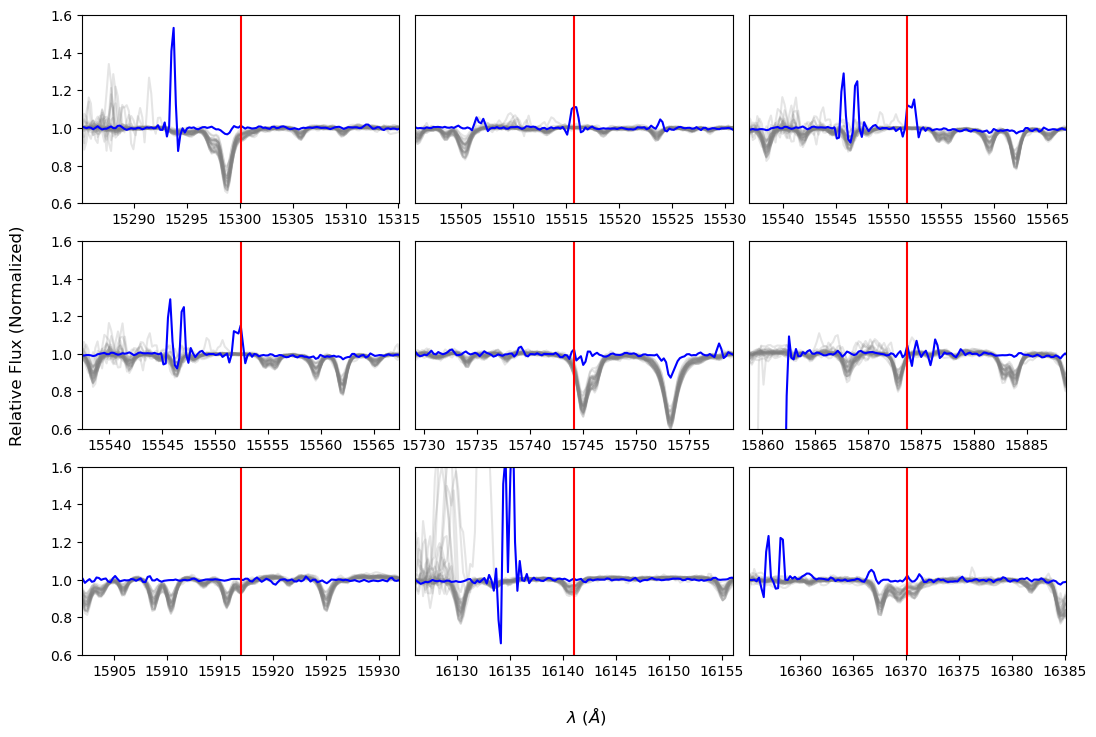

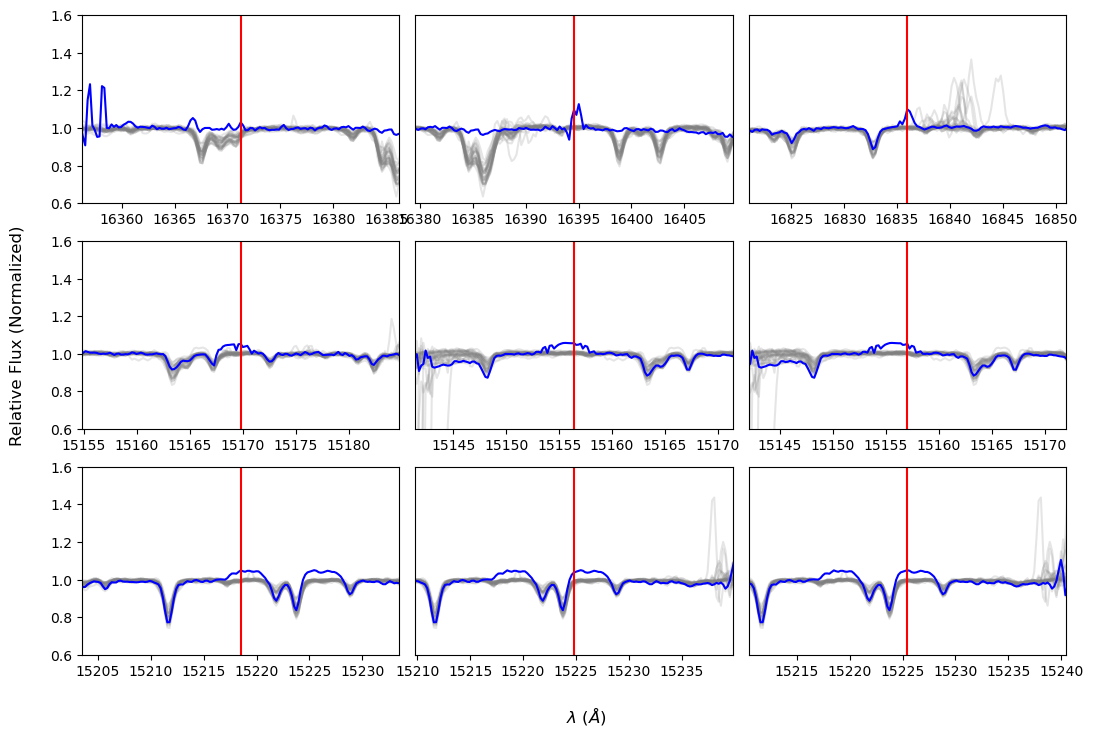

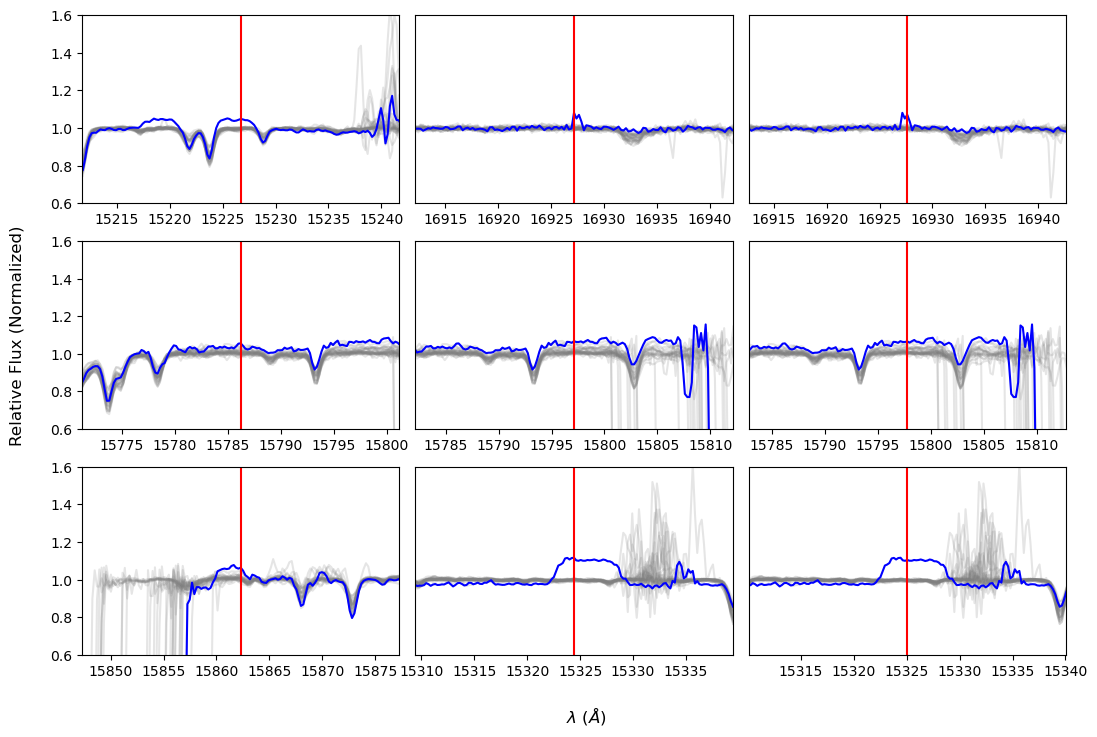

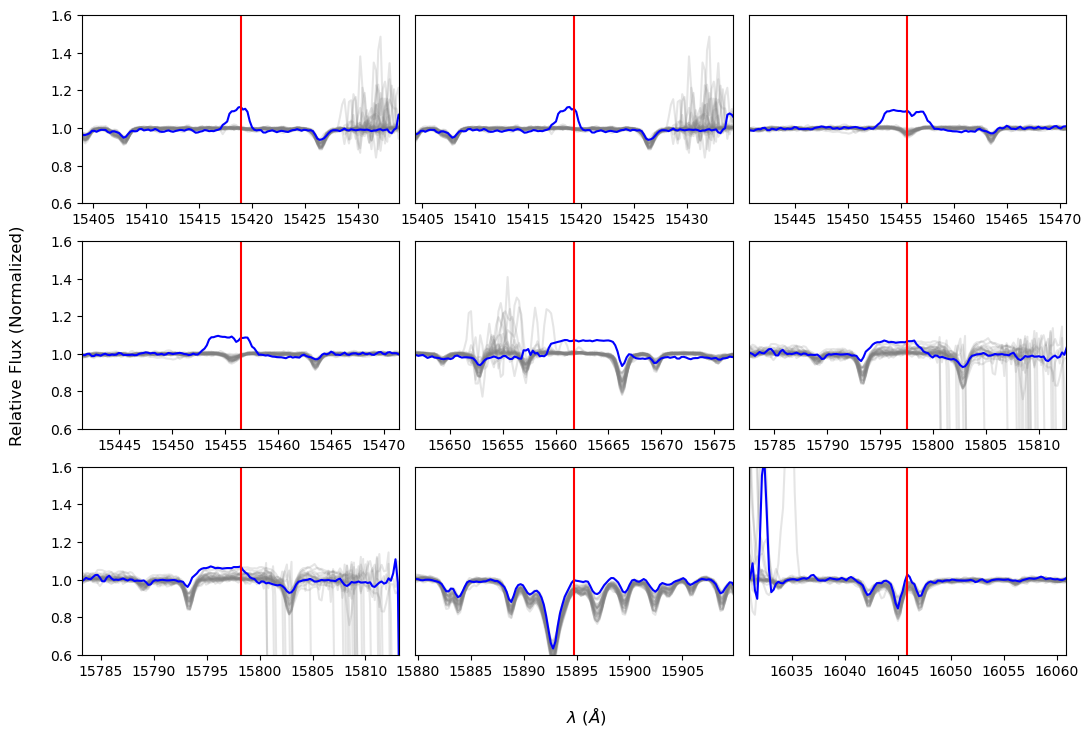

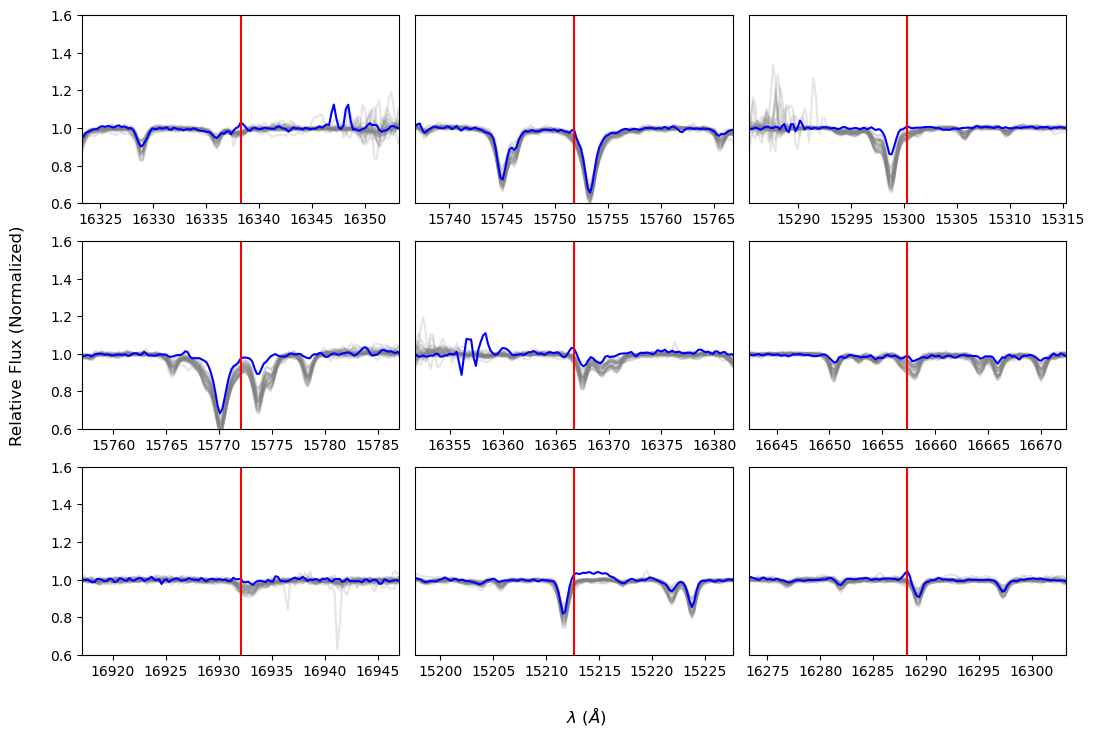

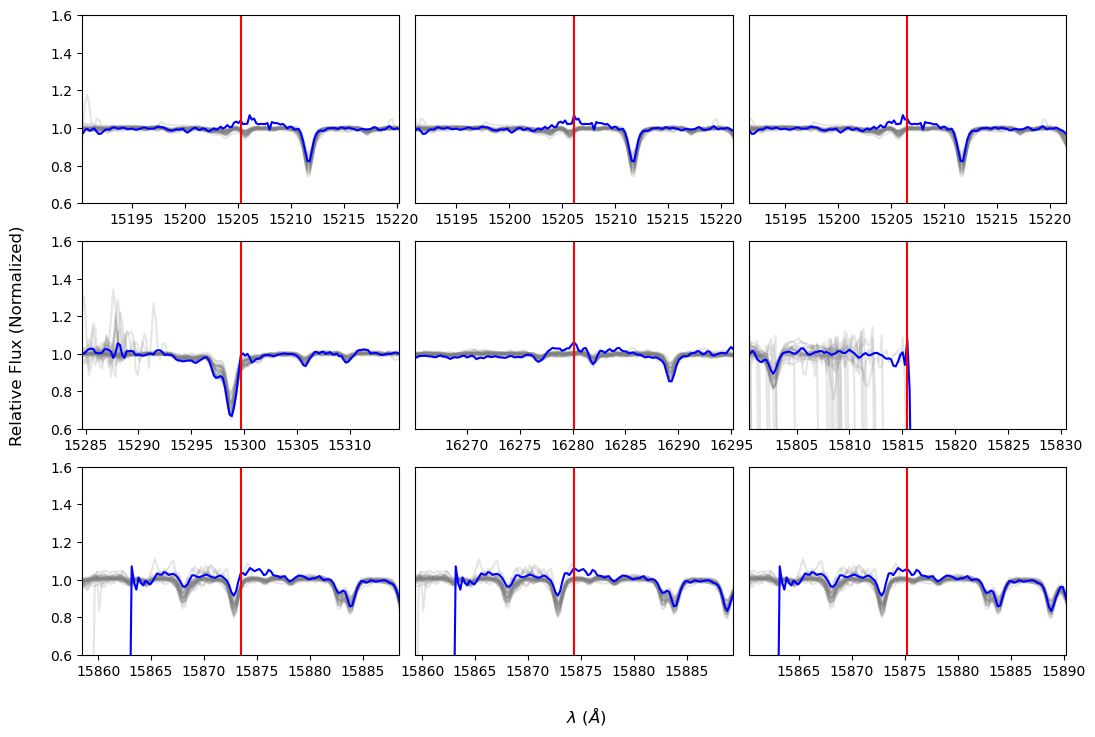

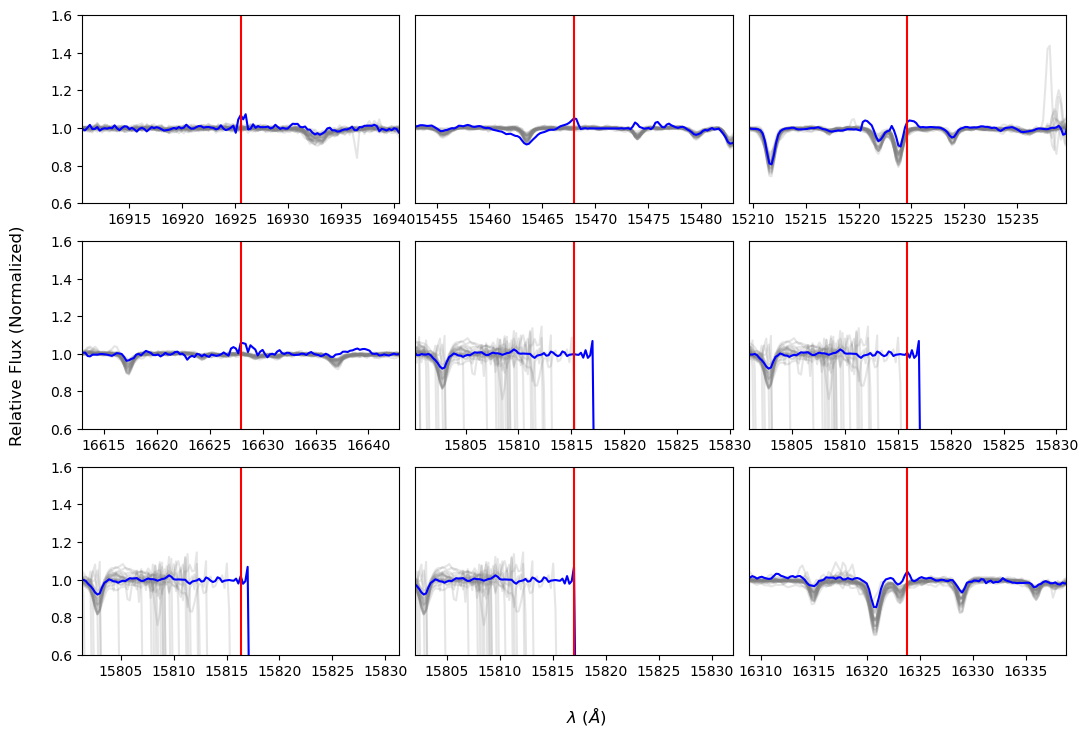

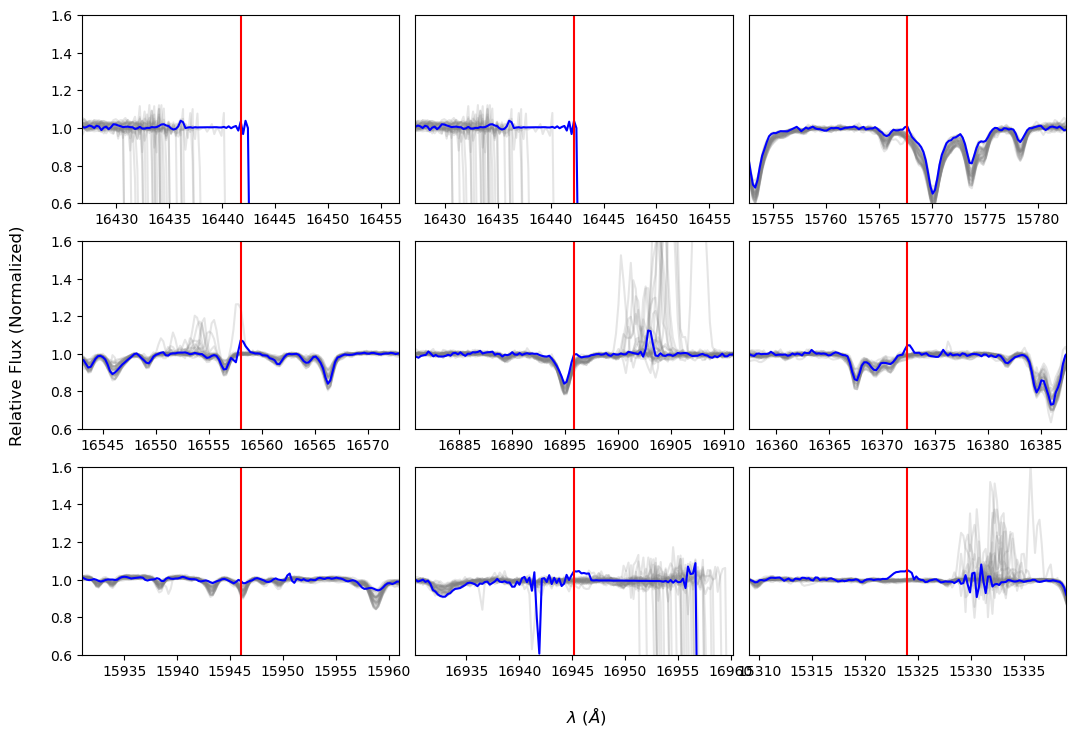

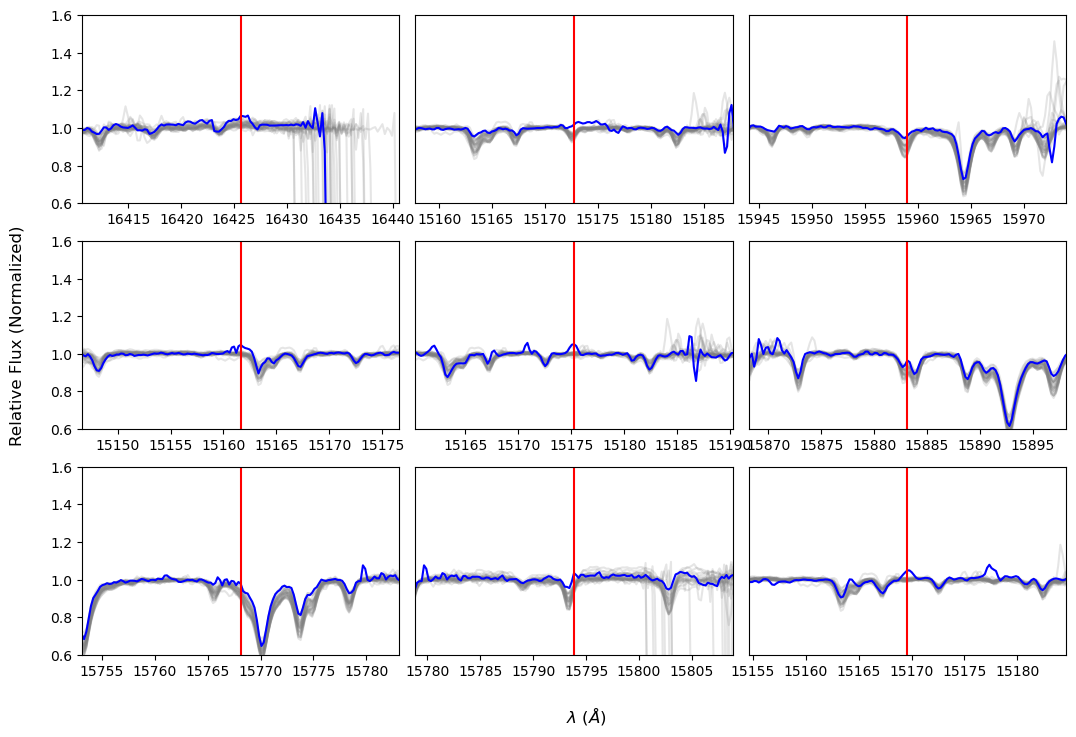

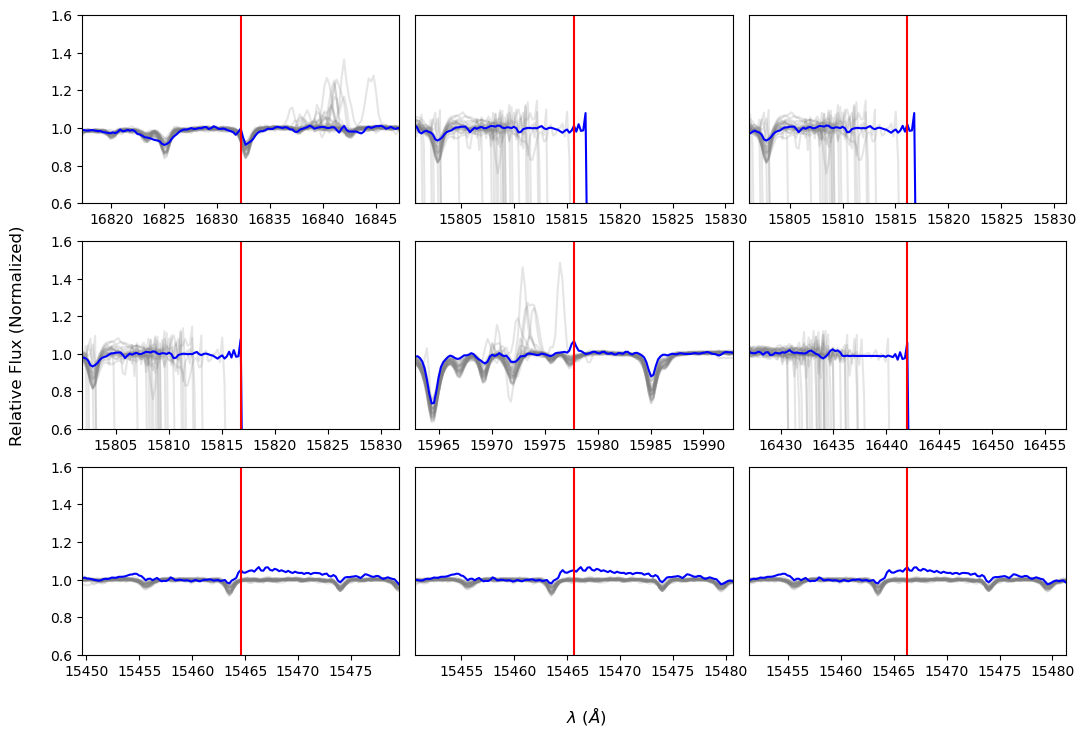

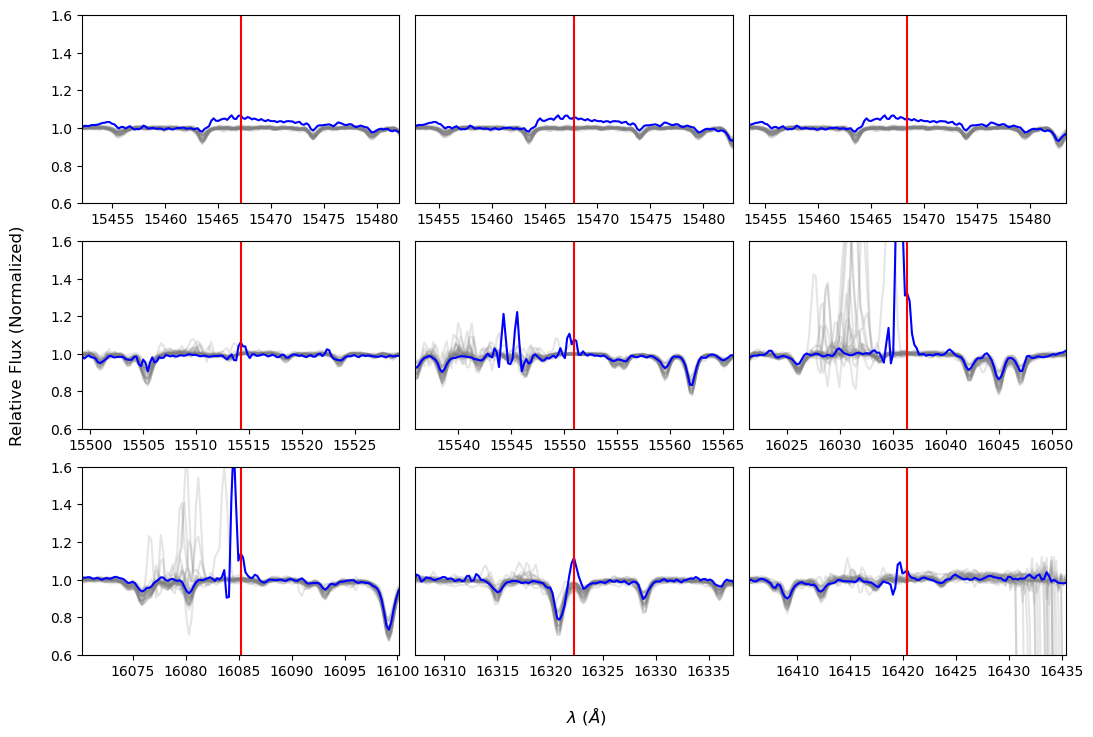

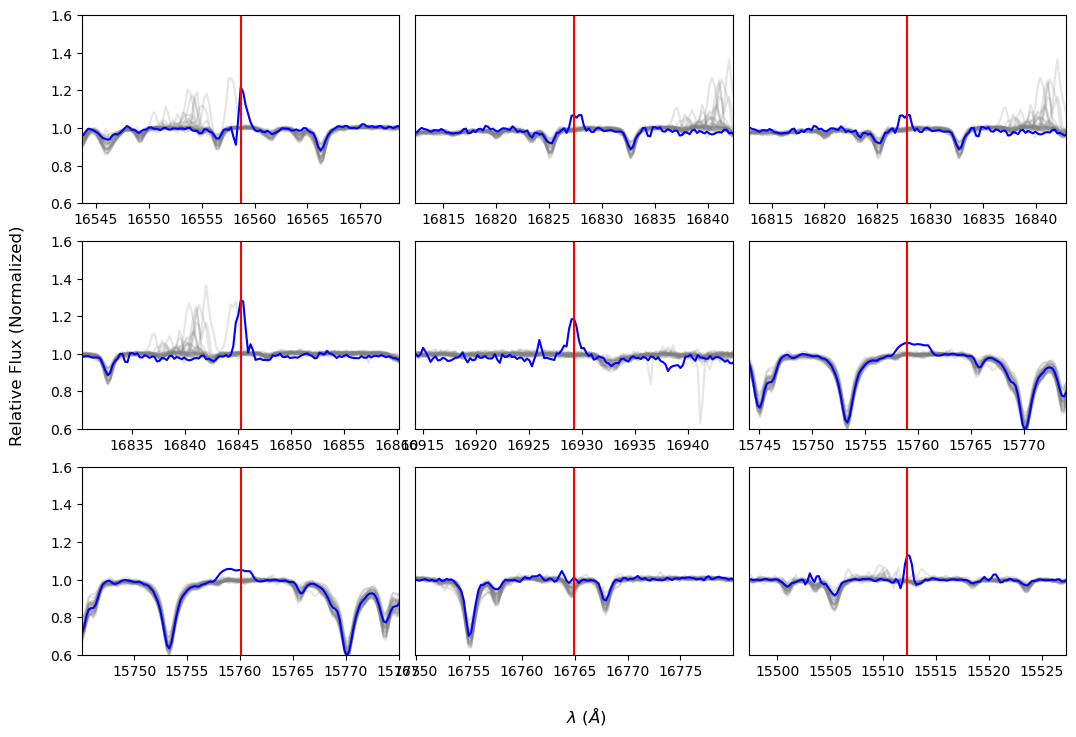

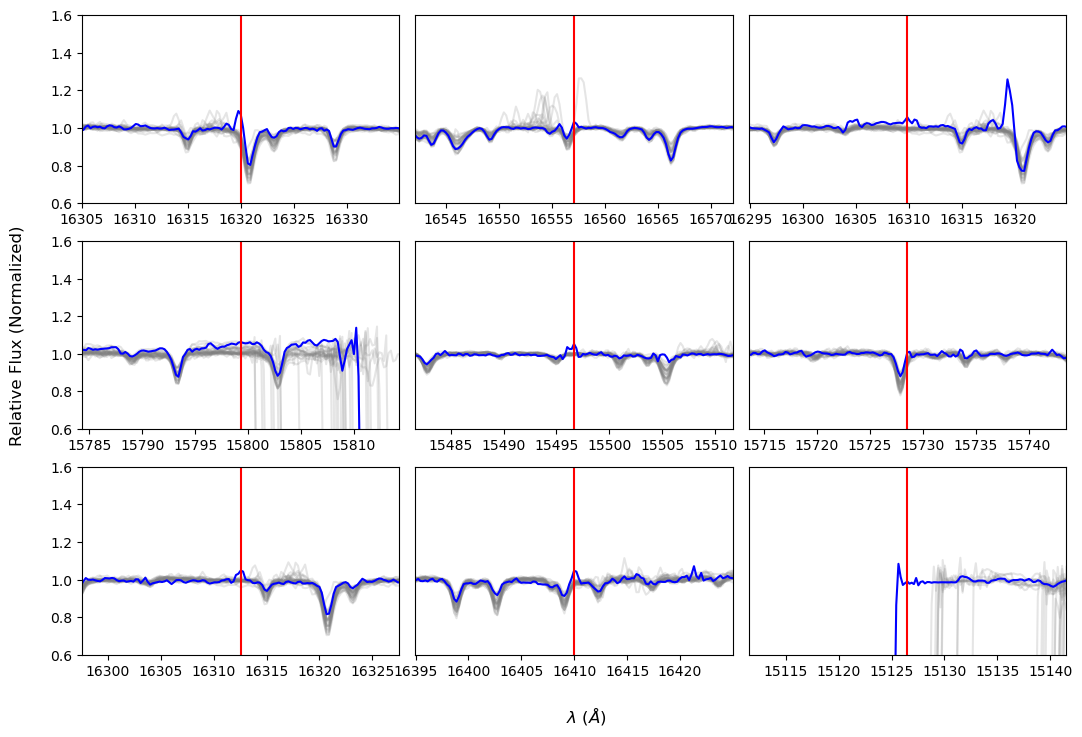

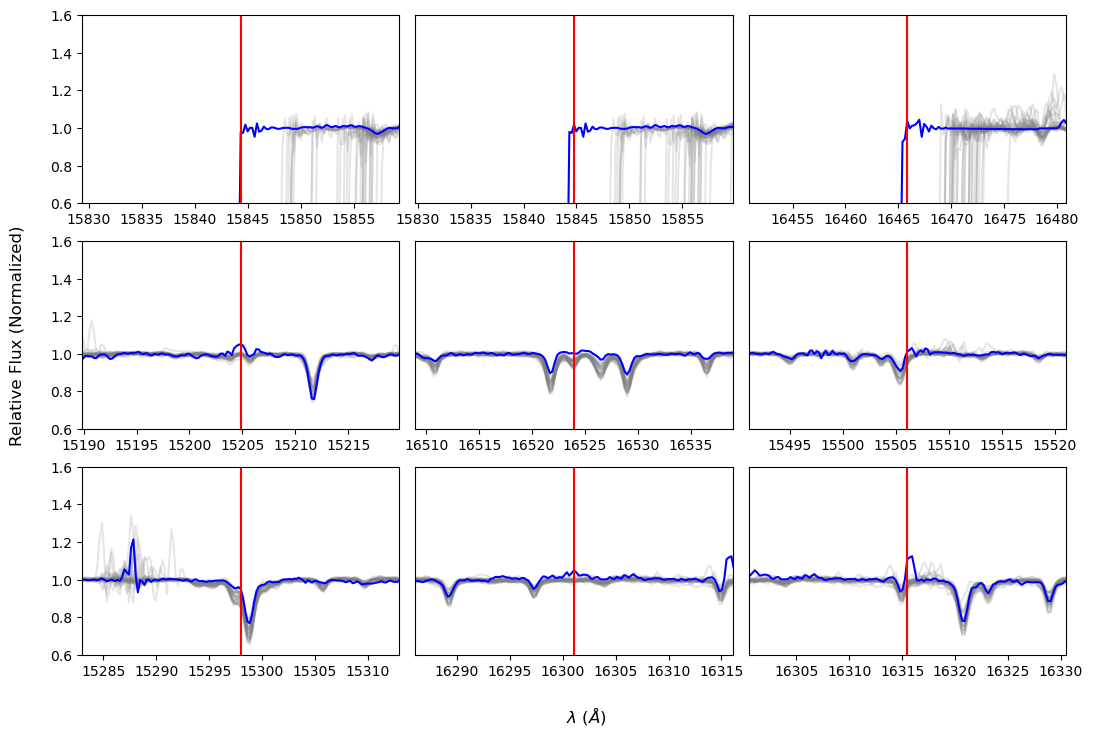

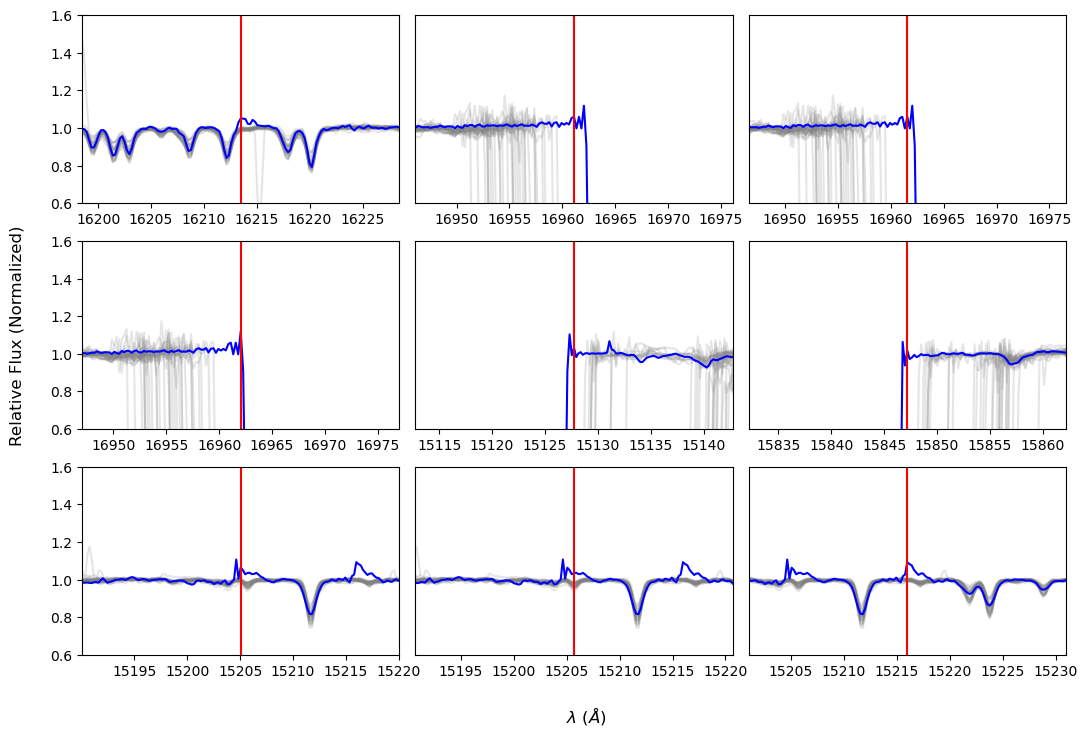

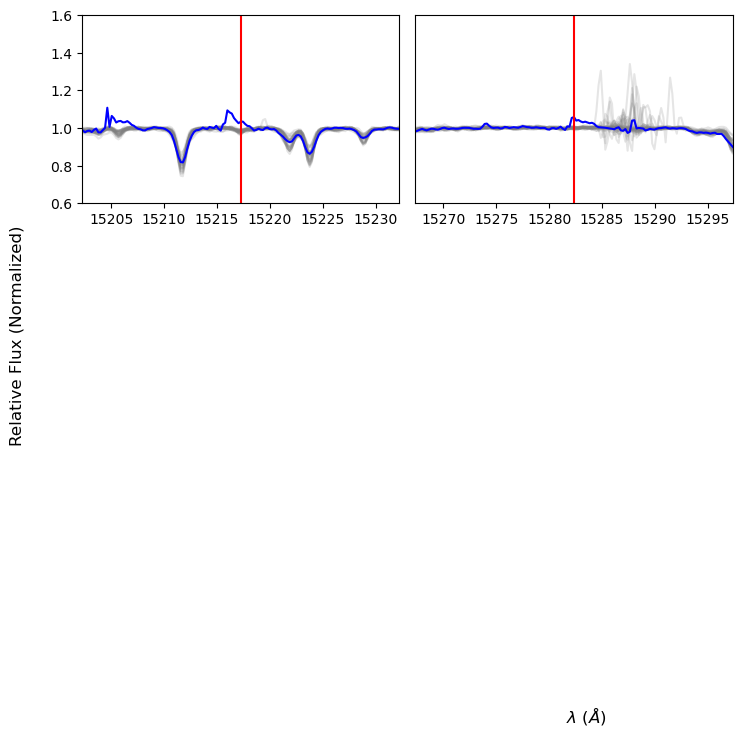

In [81]:
for j in range(0,int(len(candidates)/9 + 1)):

    fig = plt.figure(figsize=(12,8))
    
    gs = gridspec.GridSpec(3, 3, left=0.08, right=0.9, bottom=0.1, top=0.9, wspace=0.05)
    
    for i in range(0,9):
        if i + 9*j >= len(candidates):
            break
        
        ax = fig.add_subplot(gs[int(i/3), i%3])
        n = i + 9*j
        spec_id = int(candidates[n,0])

        wave = ds.wave[candidates[n,1]]
        
        ax.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
        ax.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
        ax.plot((wave, wave), (0,2), color='red')
        
        ax.set_xlim(wave - 15, wave + 15)
        ax.set_ylim(0.6, 1.6)
        #stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
        #bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        #ax.text(0.05, 0.93, stats, fontsize=9, bbox=bbox,
        #        transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
        if i%3 > 0:
            ax.set_yticks([])
    
    fig.supxlabel(r'$\lambda$ ($\AA$)')
    fig.supylabel(r'Relative Flux (Normalized)')

    fig.savefig('../data/candidates/sheet_%d.png' % j)

Categories:


